In [1]:
''' O projeto se divide em análise de timesires e uma tentativa de prever evazão
fazendo uso de um algoritmo supervisionado
----Passos Time series
1 - Baixar o Log no moodle de eventos no moodle para atividades de participação -
OK
2 - Filtrar os usuário que não são alunos - Excel -pré processamento
OK
3 - Fazer discretização(IP) - Coluna Rede_Puc
OK
4 - Adicionar uma coluna referente ao cronograma(unidade 1 e etc)
Ok
5 - Adicionar coluna com as turmas
OK
6-  Plotar gráficos com a visualização
OK
------
------ Passos Forecasting
1 - Converter a tabela de time series em um data set anterior em um transicional
    1.1 - Plotar gráfico com estatśticas gerais de uso -OK
    1.2 - Talvez clusterizar os alunos - OK
2 - Descobrir quais usuários trancaram a disciplina - Log de atividades CLI
OK
3 - Descobrir se existe uma data com pico de trancamento
OK
4 - Baseado na relação entre unidade/trancamento definir um intervalo e filtrar o dataset antes da data de interesse.
(vai ser os usuários que trancaram durante a unidade 3 e unidade 4 )
OK 

5- Mesclar com o dataset dos usuários. Adicionar mais uma coluna(trancou[1,0])
OK
6 - Alimentar random forest
OK
7 - avaliar desempenho
OK
8 - extrair regras
'''
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from datetime import datetime        
%matplotlib inline
sns.set()

In [2]:
#time series att
def rede_puc(turmas):
    ip = '139.82'
    rede = []
    for x in turmas.IP:
        if(ip == x[0:6]):
            rede.append('S')
        else:
            rede.append('N')
    turmas.insert(1, column='Rede_Puc', value=rede)#Passo 5
    return turmas

In [3]:
def obter_turmas():
    df_ = pd.DataFrame()
    frames = [df_]
    
    for dados_turma in glob.glob('dados/turmas/*'):
        grupo = dados_turma[13:-4]# obtem código do grupo
        df = pd.read_csv(dados_turma)#lê arquivo
        df.insert(3, column='Turma', value=grupo)#insere coluna
        print(df.shape)
        frames.append(df)
    dados = pd.concat(frames)

    dados = normaliza_data(dados)
    
    
    return dados



In [4]:
def normaliza_data(dados):
    dados.columns = [c.replace(' ', '_') for c in dados.columns]#Troca espaço por underline no cabeçalho
    dados.drop_duplicates(keep=False, inplace=True)#limpando dados duplicados
    dados['Data'], dados['Hora'] = dados['Hora'].str.split(' ', 1).str#divide a coluna Hora em duas colunas
    dados.Data = pd.to_datetime(dados.Data,dayfirst=True)
    return dados

In [5]:
#time series att
def obter_unidades(t): 
    unidades= []
    data_unidades = {
        'IU1':datetime(2018, 3, 19),
        'FU1':datetime(2018, 4, 18),
        'IU2':datetime(2018, 4, 18),
        'FU2':datetime(2018, 5, 9),
        'IU3':datetime(2018, 5, 9),
        'FU3':datetime(2018, 5, 23),
        'IU4':datetime(2018, 5, 23),
        'FU4':datetime(2018, 6, 27)
    }

    for x in t.Data:
        if(data_unidades['IU1'] <= x < data_unidades['FU1']):
            unidades.append('unidade_1')
        elif(data_unidades['IU2'] <= x < data_unidades['FU2']):
            unidades.append('unidade_2')
        elif(data_unidades['IU3'] <= x < data_unidades['FU3']):
            unidades.append('unidade_3')
        elif(data_unidades['IU4'] <= x < data_unidades['FU4']):
            unidades.append('unidade_4')
        else:
            unidades.append('fora_de_epoca')
            
        
    t.insert(1, column='Unidade', value=unidades)
    return t

   

In [6]:
def obter_periodo_dia(t):
    periodo = {
        'P1I':'00:00',
        'P1F':'04:00',
        'P2I':'04:00',
        'P2F':'08:00',
        'P3I':'08:00',
        'P3F':'12:00',
        'P4I':'12:00',
        'P4F':'16:00',
        'P5I':'16:00',
        'P5F':'20:00',
        'P6I':'20:00',
        'P6F':'24:00'
    }
    periodo_list = []
    for x in t.Hora:
        if (periodo['P1I'] <= x < periodo['P1F']):
            periodo_list.append('1')
        elif(periodo['P2I'] <= x < periodo['P2F']):
            periodo_list.append('2')
        elif(periodo['P3I'] <= x < periodo['P3F']):
            periodo_list.append('3')
        elif(periodo['P4I'] <= x < periodo['P4F']):
            periodo_list.append('4')
        elif(periodo['P5I'] <= x < periodo['P5F']):
            periodo_list.append('5')
        elif(periodo['P6I'] <= x < periodo['P6F']):
            periodo_list.append('6')

        
    t.insert(1, column='Periodo', value=periodo_list)
    return t

    

In [7]:
turmas = obter_turmas() 
turmas = rede_puc(turmas)
turmas = obter_unidades(turmas)
turmas = obter_periodo_dia(turmas)




turmas.to_csv('turmas.csv')

(21977, 7)
(19491, 7)
(21251, 7)
(20789, 7)
(19175, 7)


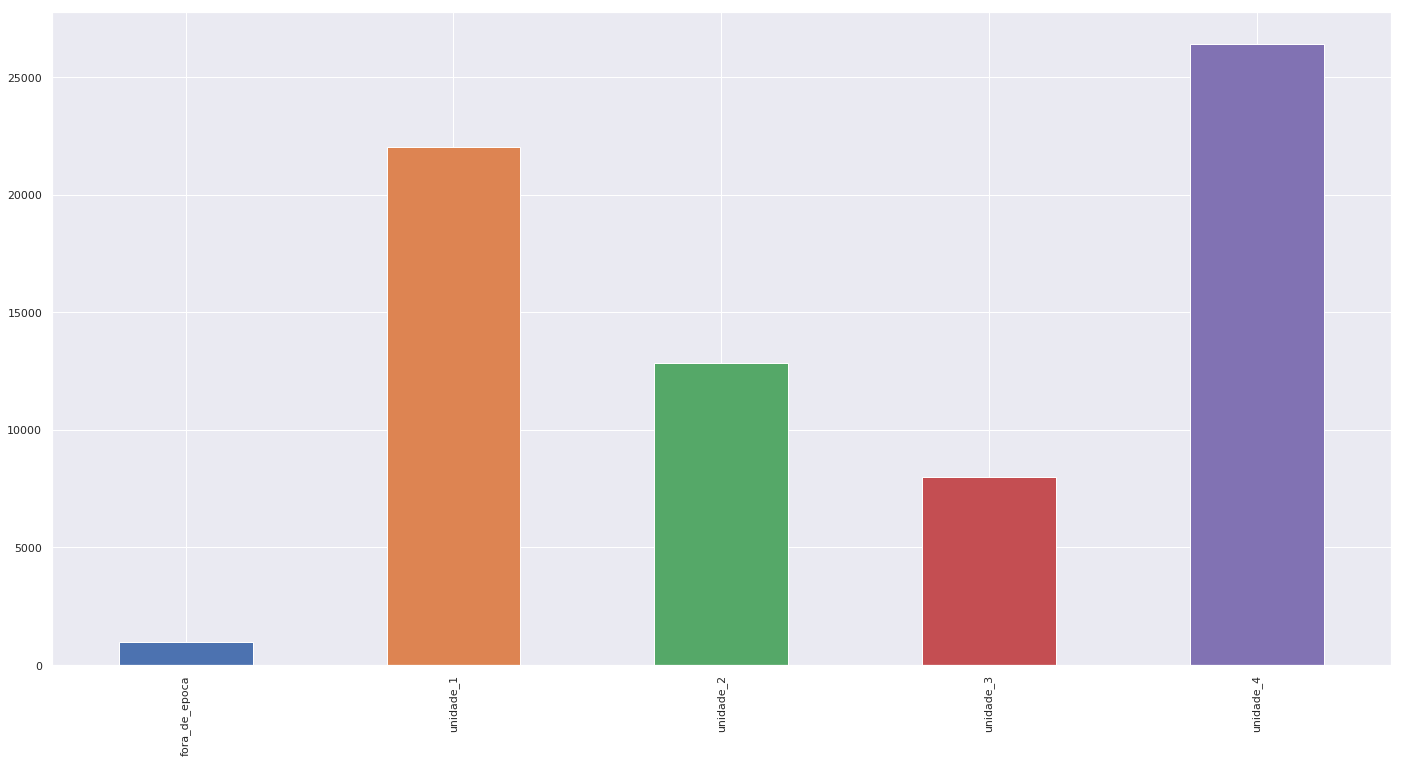

In [8]:

turmas['Unidade'].value_counts().sort_index().plot.bar(figsize=(24, 12));

In [9]:
#sns.countplot(turmas['Unidade']);

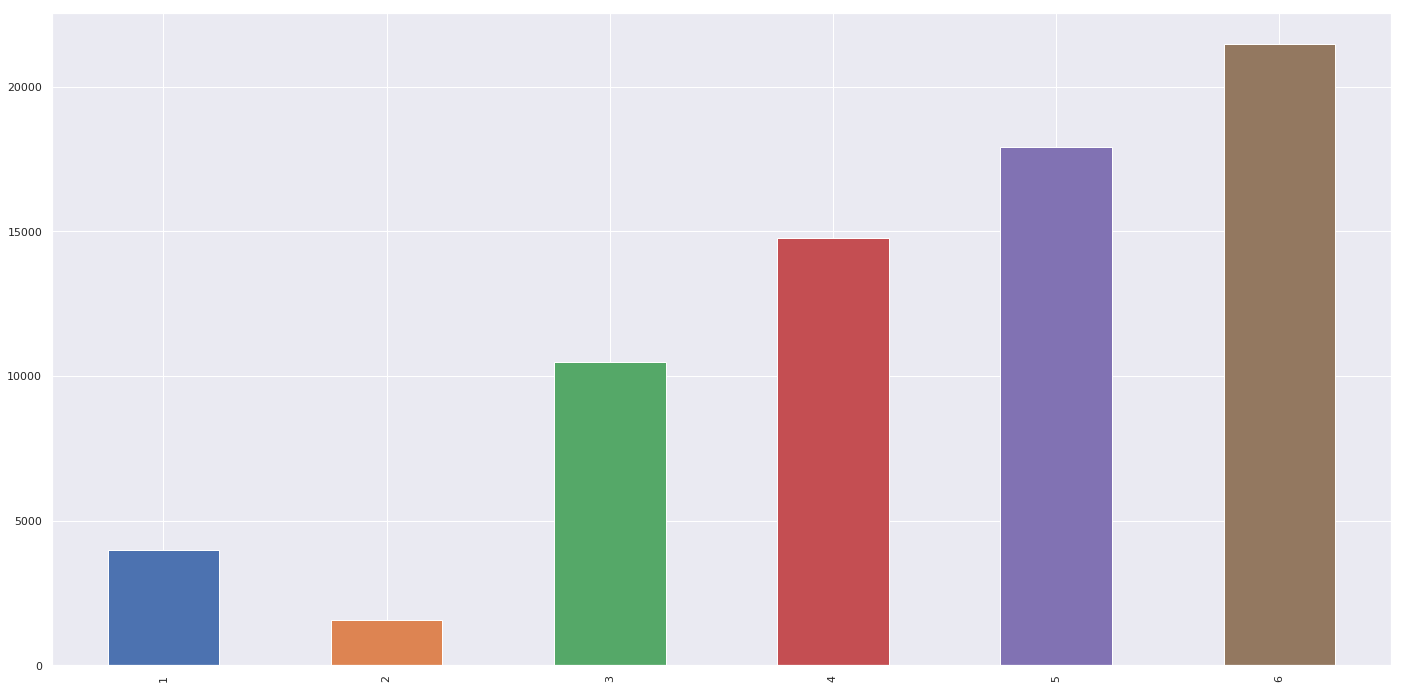

In [10]:
turmas['Periodo'].value_counts().sort_index().plot.bar(figsize=(24, 12));

In [11]:
#sns.countplot(x=turmas['Periodo'],data=turmas);

Curso: CRE1100 - O HUMANO E O FENOM RELIGIOSO - 2018.1                                                               14009
Fórum: Fórum IV - O fenômeno religioso: interpretações e grandes tradições religiosas                                 8189
Fórum: Fórum I - Experiência religiosa e as religiões no mundo contemporâneo                                          6806
Fórum: Fórum II - Quem somos nós? Refletindo sobre a pessoa humana, essa buscadora de sentido                         4309
Fórum: Fórum III - Deus e a religião em questão: visões críticas                                                      3290
Livro: 6. Dimensões fundamentais da pessoa humana: interioridade e abertura                                           2880
Livro: 9. Principais críticos da religião e da existência de Deus: L. Feuerbach, K. Marx, F. Nietzsche e S. Freud     2462
Livro: 10. Categorias de interpretação do fenômeno religioso                                                          2375
Livro: 8. O huma

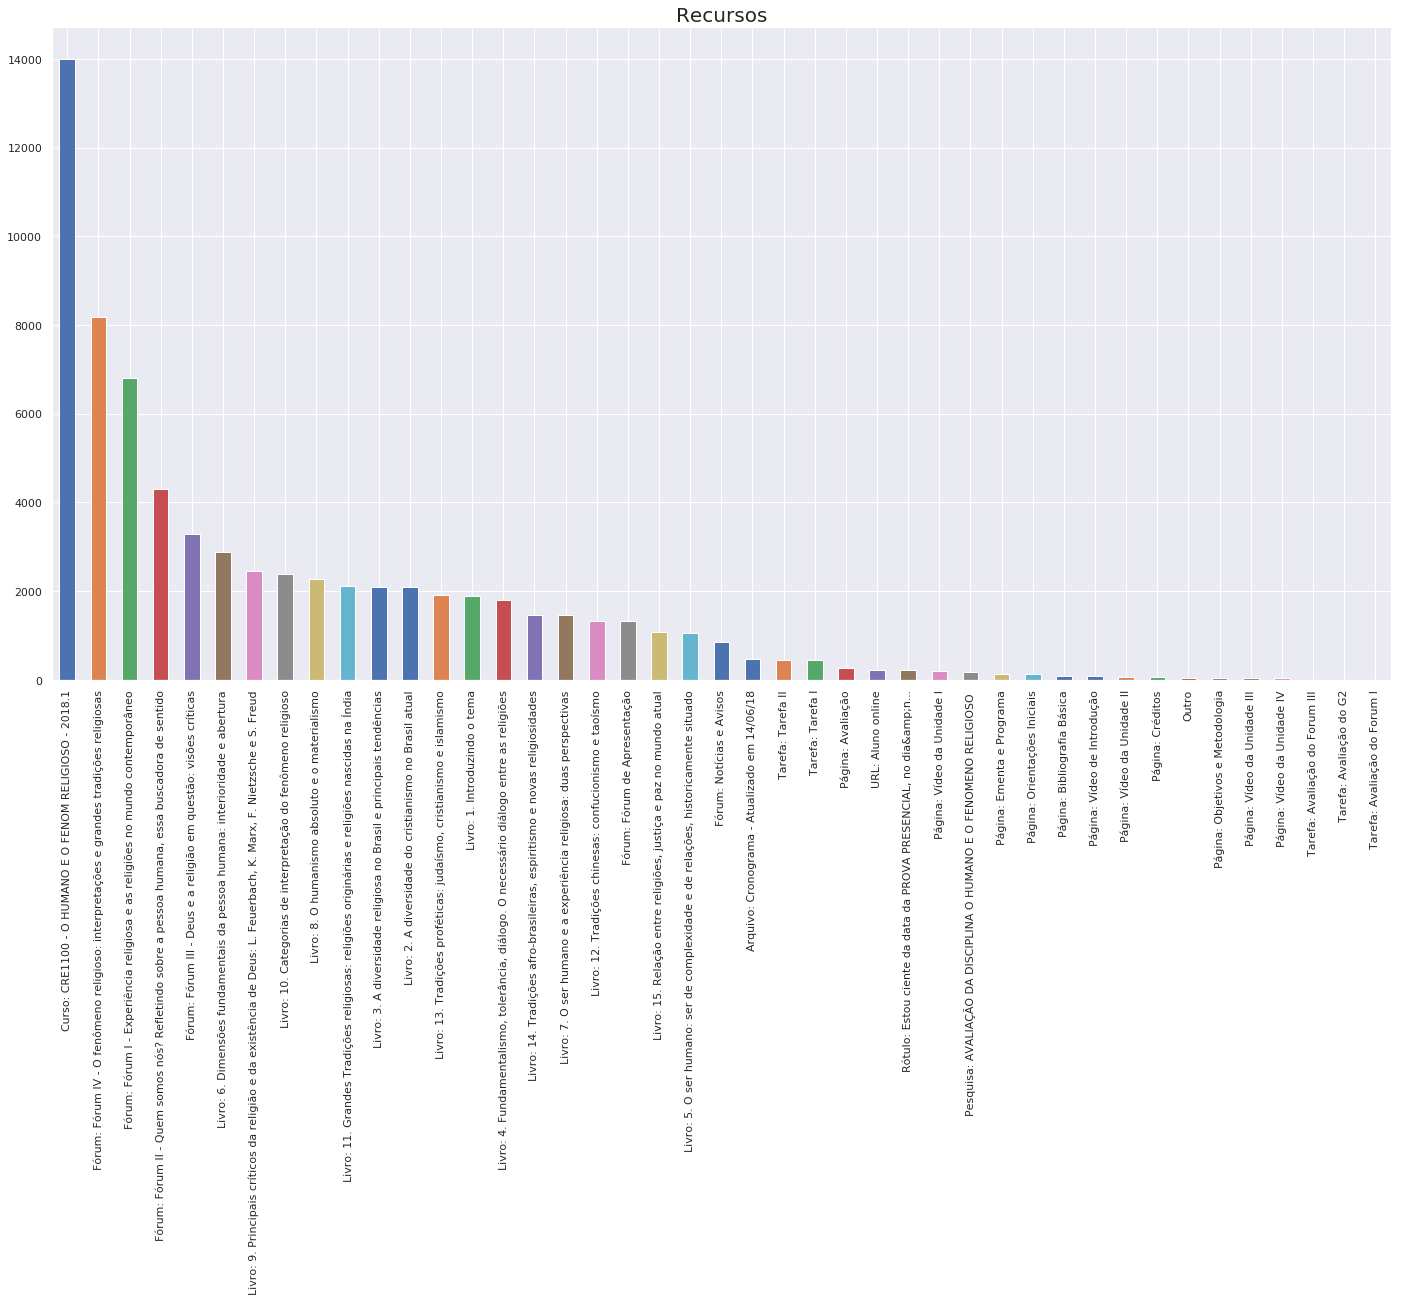

In [12]:
recursos = turmas['Contexto_do_Evento'].value_counts().plot.bar(figsize=(24, 12));
recursos.set_title("Recursos", fontsize=20);
print(turmas['Contexto_do_Evento'].value_counts())


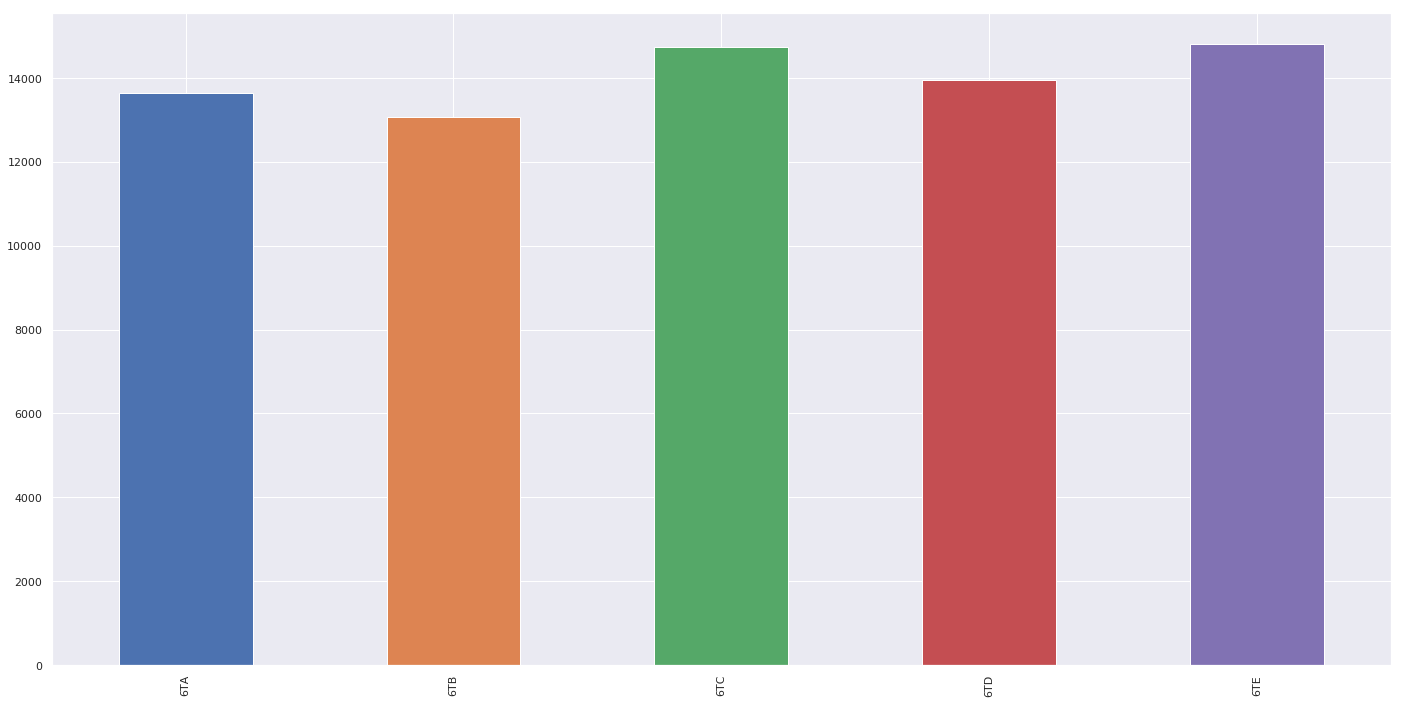

In [13]:
turmas['Turma'].value_counts().sort_index().plot.bar(figsize=(24, 12));


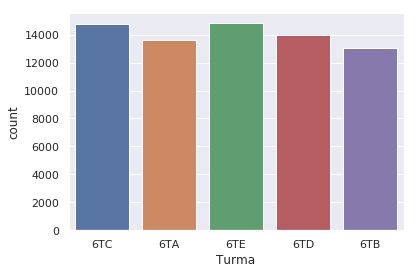

In [14]:
sns.countplot(x=turmas['Turma'],data=turmas);

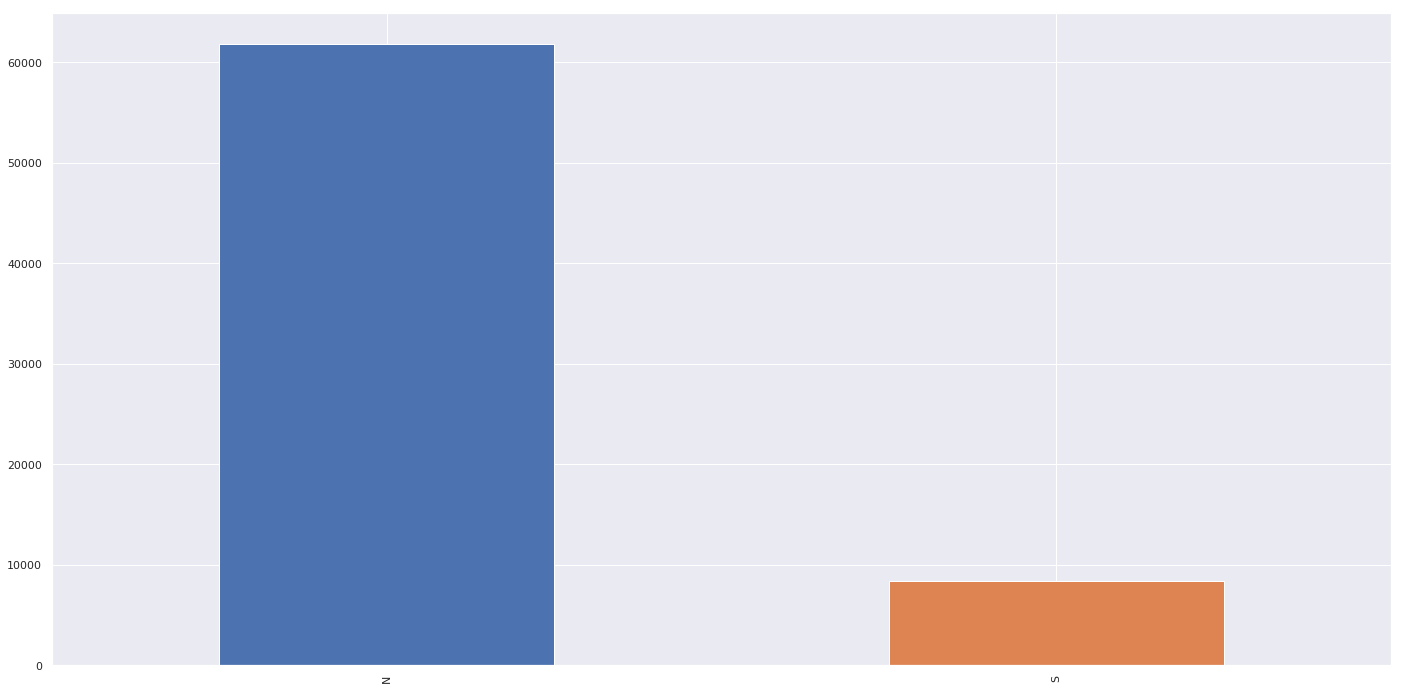

In [15]:
turmas['Rede_Puc'].value_counts().sort_index().plot.bar(figsize=(24, 12));


In [16]:
#Parte 2
turmas_pre_clean=turmas.groupby('Nome_completo')['Contexto_do_Evento'].value_counts().sort_index().unstack().fillna(0)#tranformando timesires em data frame
#turmas_pre_clean.head()

In [17]:
turmas_pre_clean.describe()


Contexto_do_Evento,Arquivo: Cronograma - Atualizado em 14/06/18,Curso: CRE1100 - O HUMANO E O FENOM RELIGIOSO - 2018.1,Fórum: Fórum I - Experiência religiosa e as religiões no mundo contemporâneo,"Fórum: Fórum II - Quem somos nós? Refletindo sobre a pessoa humana, essa buscadora de sentido",Fórum: Fórum III - Deus e a religião em questão: visões críticas,Fórum: Fórum IV - O fenômeno religioso: interpretações e grandes tradições religiosas,Fórum: Fórum de Apresentação,Fórum: Notícias e Avisos,Livro: 1. Introduzindo o tema,Livro: 10. Categorias de interpretação do fenômeno religioso,...,Página: Vídeo da Unidade III,Página: Vídeo da Unidade IV,Página: Vídeo de Introdução,"Rótulo: Estou ciente da data da PROVA PRESENCIAL, no dia&amp;n...",Tarefa: Avaliação do Forum I,Tarefa: Avaliação do Forum III,Tarefa: Avaliação do G2,Tarefa: Tarefa I,Tarefa: Tarefa II,URL: Aluno online
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,...,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,2.950000,87.556250,42.537500,26.931250,20.562500,51.181250,8.275000,5.275000,11.818750,14.843750,...,0.243750,0.187500,0.512500,1.356250,0.006250,0.018750,0.006250,2.737500,2.806250,1.375000
std,2.964783,43.810304,17.772457,14.875636,10.007976,22.113735,5.640097,7.561031,7.829851,10.385977,...,0.485602,0.451239,0.663396,0.763531,0.079057,0.176331,0.079057,1.295796,1.118719,1.325844
min,0.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,56.750000,30.000000,16.000000,14.000000,36.000000,4.000000,1.000000,7.000000,6.750000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000
50%,2.000000,79.000000,41.000000,26.000000,19.000000,48.000000,9.000000,3.000000,11.000000,15.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,3.000000,1.000000
75%,4.000000,112.250000,50.500000,37.000000,25.000000,63.250000,11.000000,7.000000,15.000000,20.000000,...,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,3.000000,2.000000
max,16.000000,275.000000,117.000000,89.000000,59.000000,120.000000,29.000000,60.000000,54.000000,44.000000,...,3.000000,3.000000,3.000000,4.000000,1.000000,2.000000,1.000000,9.000000,9.000000,8.000000


In [18]:
from sklearn.cluster import KMeans
from sklearn import decomposition
def cluster(t):
    data=t
    kmeans = KMeans(n_clusters = 3, init = 'k-means++')
    kmeans = kmeans.fit(data)
    plot_2D_cluster(data,kmeans)
    plot_3D_cluster(data,kmeans)
    return kmeans
    
    

In [19]:
def plot_2D_cluster(data,kmeans):
    pca = decomposition.PCA()
    pca.n_components = 2
    X_reduced = pca.fit_transform(data)
    values = kmeans.cluster_centers_.squeeze()
    labels = kmeans.labels_
    centroid = pca.fit_transform(values)
    centroid_label = set(labels) 
    plt.scatter(X_reduced[:,0],X_reduced[:,1],c=labels,cmap='tab20')
    #plt.scatter(centroid[:,0],centroid[:,1],c=range(0,len(centroid_label)),cmap='Set1',marker='D')
    plt.show()
    

In [20]:
from mpl_toolkits.mplot3d import Axes3D
def plot_3D_cluster(data,kmeans):
    fig = plt.figure()
    ax = Axes3D(fig)
    
    pca = decomposition.PCA()
    pca.n_components = 3
    X_reduced = pca.fit_transform(data)
    values = kmeans.cluster_centers_.squeeze()
    labels = kmeans.labels_
    centroid = pca.fit_transform(values)
    centroid_label = set(labels) 
    
    ax.scatter(X_reduced[:,0],X_reduced[:,1],X_reduced[:,1] , c=labels,cmap='tab20')
    #ax.scatter(centroid[:,0],centroid[:,1],centroid[:,2],c=range(0,len(centroid_label)),cmap='Set1',marker='D')
    plt.show()

In [21]:
def obter_trancamentos():
    trancamento = pd.read_csv('dados/trancamento.csv')
    trancamento = normaliza_data(trancamento)
    filtro = trancamento[trancamento.Data < '2018-06-27 08:00:00']#filtra a data
    return filtro

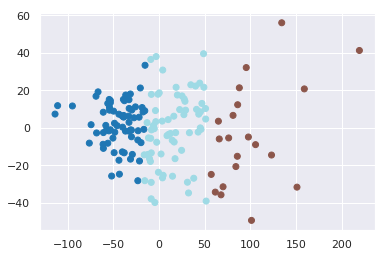

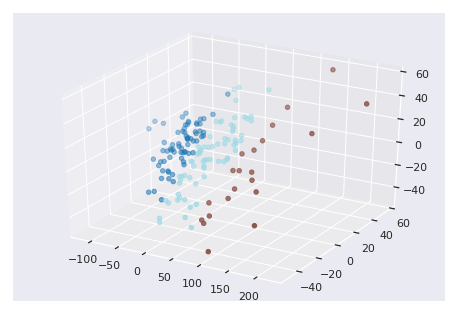

In [22]:
kmeans = cluster(turmas_pre_clean.iloc[:, :,].values)
#3-5-8

In [23]:
turmas_pre_clean.to_csv('alunos_clean.csv')

In [24]:
alunos_clean = pd.read_csv('alunos_clean.csv')
#alunos_clean.head(3)

In [25]:
from slugify import slugify
def obter_log_evadidos (evasao):
    # Remove usuários que trancaram a disciplina no periodo fora de interesse
    target = evasao[(evasao.Unidade == 'unidade_3') | (evasao.Unidade == 'unidade_4')]
    target.sort_values(by='Data')
    id_alunos = []
    for i in target['Evento']:
        id_alunos.append(i[-36:-31])#usados na query
        
    alunos_evadidos =  pd.read_csv('dados/trancamento_clean.csv')
 
    return alunos_evadidos
    

In [26]:
describe = alunos_clean.describe()
describe.to_csv('metricas.csv')

In [27]:
evasao = obter_trancamentos()
print(len(evasao))
evasao = obter_unidades(evasao)
#evasao.head(3)

58


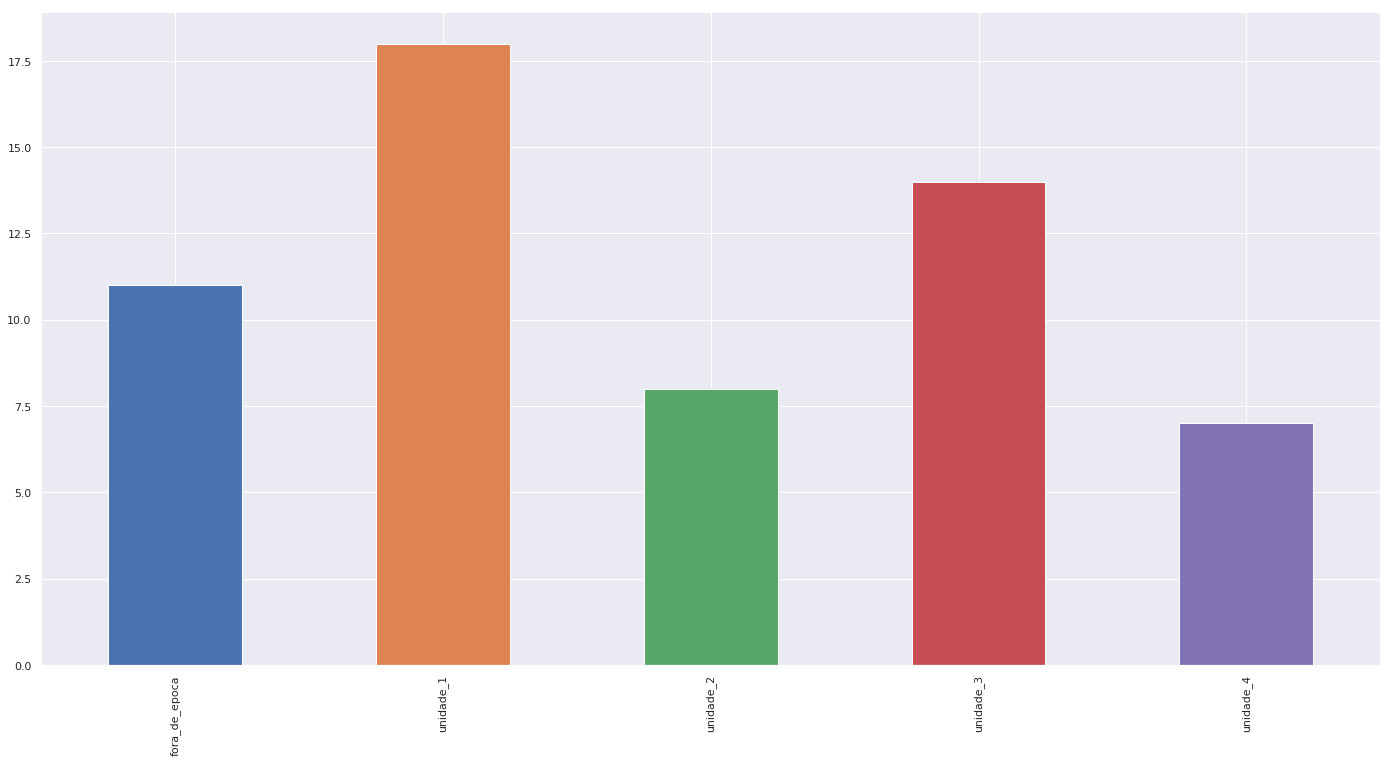

In [28]:
evasao['Unidade'].value_counts().sort_index().plot.bar(figsize=(24, 12));

In [29]:

log_evadidos = obter_log_evadidos(evasao)

#log_evadidos.head(3)



Fórum: Fórum I - Experiência religiosa e as religiões no mundo contemporâneo                     535
Livro: 2. A diversidade do cristianismo no Brasil atual                                          258
Livro: 1. Introduzindo o tema                                                                    238
Tarefa: Tarefa I                                                                                 201
Livro: 3. A diversidade religiosa no Brasil e principais tendências                              195
Fórum: Fórum II - Quem somos nós? Refletindo sobre a pessoa humana, essa buscadora de sentido    193
Livro: 6. Dimensões fundamentais da pessoa humana: interioridade e abertura                      176
Livro: 4. Fundamentalismo, tolerância, diálogo. O necessário diálogo entre as religiões          174
Tarefa: Tarefa II                                                                                120
Livro: 5. O ser humano: ser de complexidade e de relações, historicamente situado          

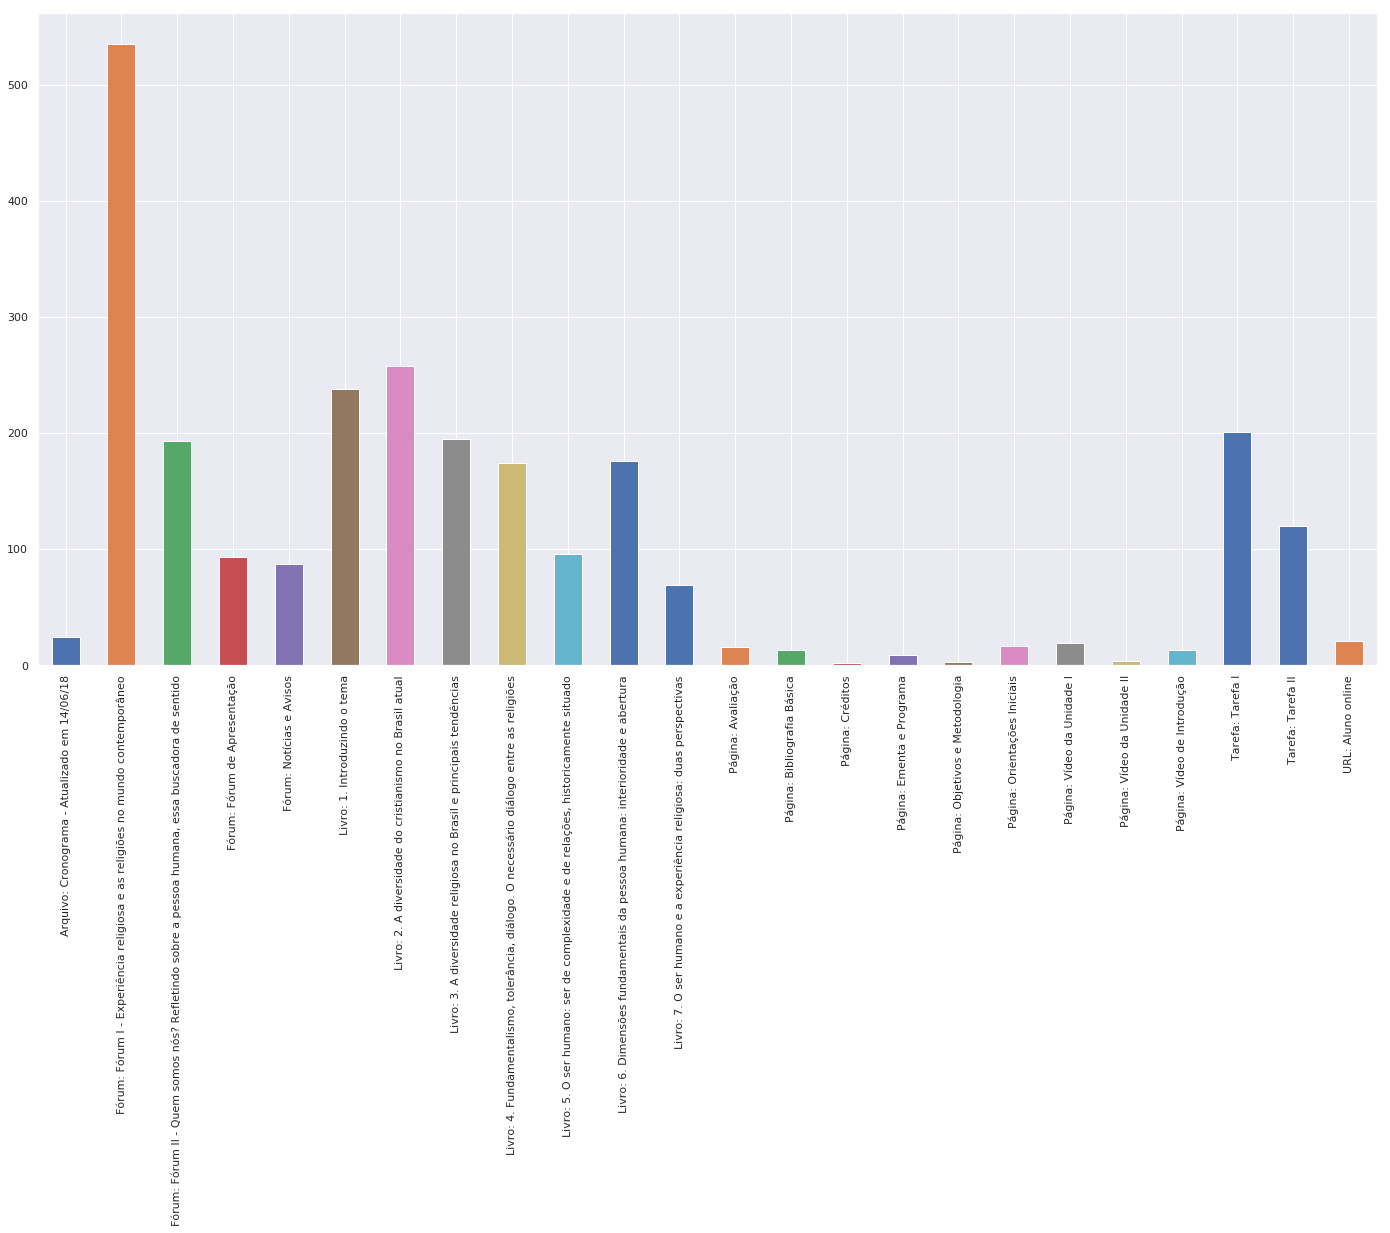

In [31]:
print(log_evadidos['component'].value_counts())
log_evadidos['component'].value_counts().sort_index().plot.bar(figsize=(24, 12));

In [32]:
evadidos_data=log_evadidos.groupby('userid')['component'].value_counts().sort_index().unstack().fillna(0)#tranformando timesires em data frame
evadidos_data.to_csv('evadidos_count.csv')
evadidos_data = pd.read_csv('evadidos_count.csv')
print(len(evadidos_data))
print(len(alunos_clean))

19
160


In [33]:
def merge_alunos(evadidos, alunos_clean):
    #evadidos.rename(columns={'userid':'Nome_completo'}, inplace=True)
    evadidos.drop(['userid'], axis=1)
    alunos_clean.drop(['Nome_completo'], axis=1)
    
    alunos_clean['Trancou'] = 0
    evadidos['Trancou'] = 1
    return pd.concat([alunos_clean, evadidos_data],join="inner",sort=True,ignore_index=True)
    

    
    

In [34]:
evadidos_data.head()
alunos_final = merge_alunos(evadidos_data, alunos_clean)
alunos_final.describe()

,Arquivo: Cronograma - Atualizado em 14/06/18,Fórum: Fórum I - Experiência religiosa e as religiões no mundo contemporâneo,"Fórum: Fórum II - Quem somos nós? Refletindo sobre a pessoa humana, essa buscadora de sentido",Fórum: Fórum de Apresentação,Fórum: Notícias e Avisos,Livro: 1. Introduzindo o tema,Livro: 2. A diversidade do cristianismo no Brasil atual,Livro: 3. A diversidade religiosa no Brasil e principais tendências,"Livro: 4. Fundamentalismo, tolerância, diálogo. O necessário diálogo entre as religiões","Livro: 5. O ser humano: ser de complexidade e de relações, historicamente situado",...,Página: Ementa e Programa,Página: Objetivos e Metodologia,Página: Orientações Iniciais,Página: Vídeo da Unidade I,Página: Vídeo da Unidade II,Página: Vídeo de Introdução,Tarefa: Tarefa I,Tarefa: Tarefa II,Trancou,URL: Aluno online
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,...,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,2.770950,41.011173,25.150838,7.916201,5.201117,11.893855,13.100559,12.804469,11.044693,6.435754,...,0.843575,0.268156,0.865922,1.262570,0.346369,0.530726,3.569832,3.178771,0.106145,1.346369
std,2.906414,17.904236,15.377082,5.714039,7.470827,7.912081,8.130325,8.002161,7.303856,5.338019,...,1.160250,0.614106,1.002195,0.984884,0.553463,0.672832,4.001318,2.572848,0.308887,1.286326
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,29.000000,13.000000,3.000000,1.000000,7.000000,8.000000,8.000000,7.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000
50%,2.000000,39.000000,25.000000,8.000000,3.000000,11.000000,12.000000,12.000000,10.000000,6.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000,3.000000,0.000000,1.000000
75%,4.000000,49.000000,35.000000,11.000000,6.500000,15.000000,17.000000,18.000000,14.000000,10.000000,...,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,3.000000,3.000000,0.000000,2.000000
max,16.000000,117.000000,89.000000,29.000000,60.000000,54.000000,42.000000,46.000000,43.000000,21.000000,...,6.000000,4.000000,5.000000,5.000000,2.000000,3.000000,37.000000,21.000000,1.000000,8.000000


In [35]:
dados_finais = alunos_final.drop(['Trancou'], axis=1)
targets_finais = alunos_final['Trancou']
#targets_finais

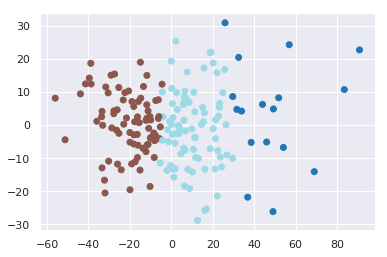

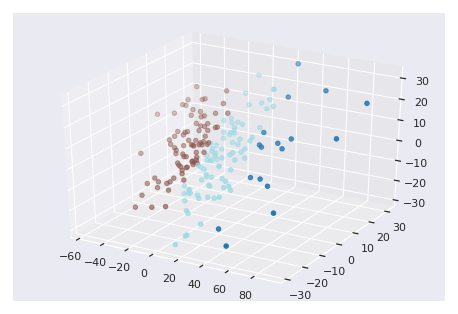

In [36]:
todos = dados_finais[dados_finais != 'Trancou']
cluster(todos.values);

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dados_finais.values, 
 targets_finais.values, 
 test_size = 0.4, 
 random_state = 0)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 107 samples.
Testing set has 72 samples.


In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, n_estimators = 200, class_weight="balanced")
model = rf.fit(X_train, y_train)


/home/ronnald/dev/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [39]:
resultado = rf.predict(X_test)


In [40]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_test, resultado)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


precision: [0.90140845 1.        ]
recall: [1.    0.125]
fscore: [0.94814815 0.22222222]
support: [64  8]


In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(resultado, y_test)

array([[64,  7],
       [ 0,  1]])

In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
scaler.fit(X_test)
NB = GaussianNB()
NB.fit(X_train, y_train)

GaussianNB(priors=None)

In [43]:
resultadoNB = NB.predict(X_test)

 

In [44]:
precisionNB, recallNB, fscoreNB, supportNB = score(y_test, resultadoNB)

print('precision: {}'.format(precisionNB))
print('recall: {}'.format(recallNB))
print('fscore: {}'.format(fscoreNB))
print('support: {}'.format(supportNB))
print(confusion_matrix(resultadoNB, y_test))

precision: [0.96969697 1.        ]
recall: [1.   0.75]
fscore: [0.98461538 0.85714286]
support: [64  8]
[[64  2]
 [ 0  6]]


In [45]:
alunos_final

,Arquivo: Cronograma - Atualizado em 14/06/18,Fórum: Fórum I - Experiência religiosa e as religiões no mundo contemporâneo,"Fórum: Fórum II - Quem somos nós? Refletindo sobre a pessoa humana, essa buscadora de sentido",Fórum: Fórum de Apresentação,Fórum: Notícias e Avisos,Livro: 1. Introduzindo o tema,Livro: 2. A diversidade do cristianismo no Brasil atual,Livro: 3. A diversidade religiosa no Brasil e principais tendências,"Livro: 4. Fundamentalismo, tolerância, diálogo. O necessário diálogo entre as religiões","Livro: 5. O ser humano: ser de complexidade e de relações, historicamente situado",...,Página: Ementa e Programa,Página: Objetivos e Metodologia,Página: Orientações Iniciais,Página: Vídeo da Unidade I,Página: Vídeo da Unidade II,Página: Vídeo de Introdução,Tarefa: Tarefa I,Tarefa: Tarefa II,Trancou,URL: Aluno online
0,2.0,59.0,38.0,8.0,2.0,19.0,30.0,17.0,12.0,7.0,...,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,0,1.0
1,3.0,47.0,29.0,9.0,18.0,14.0,6.0,10.0,11.0,10.0,...,1.0,1.0,3.0,0.0,0.0,0.0,3.0,3.0,0,2.0
2,2.0,27.0,13.0,9.0,0.0,6.0,10.0,0.0,9.0,8.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0,3.0
3,4.0,40.0,25.0,12.0,0.0,13.0,14.0,19.0,16.0,6.0,...,1.0,1.0,1.0,1.0,1.0,0.0,3.0,3.0,0,3.0
4,1.0,33.0,26.0,7.0,4.0,2.0,4.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0,1.0
5,2.0,44.0,29.0,10.0,2.0,9.0,10.0,3.0,8.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,0,1.0
6,3.0,62.0,31.0,0.0,9.0,19.0,17.0,7.0,14.0,12.0,...,2.0,1.0,1.0,2.0,2.0,0.0,3.0,1.0,0,2.0
7,7.0,81.0,34.0,27.0,8.0,54.0,21.0,17.0,12.0,21.0,...,3.0,2.0,2.0,4.0,1.0,2.0,3.0,3.0,0,3.0
8,4.0,34.0,31.0,0.0,0.0,4.0,11.0,9.0,5.0,6.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,3.0
9,4.0,26.0,30.0,4.0,8.0,2.0,14.0,10.0,2.0,9.0,...,1.0,0.0,0.0,1.0,0.0,1.0,3.0,3.0,0,2.0


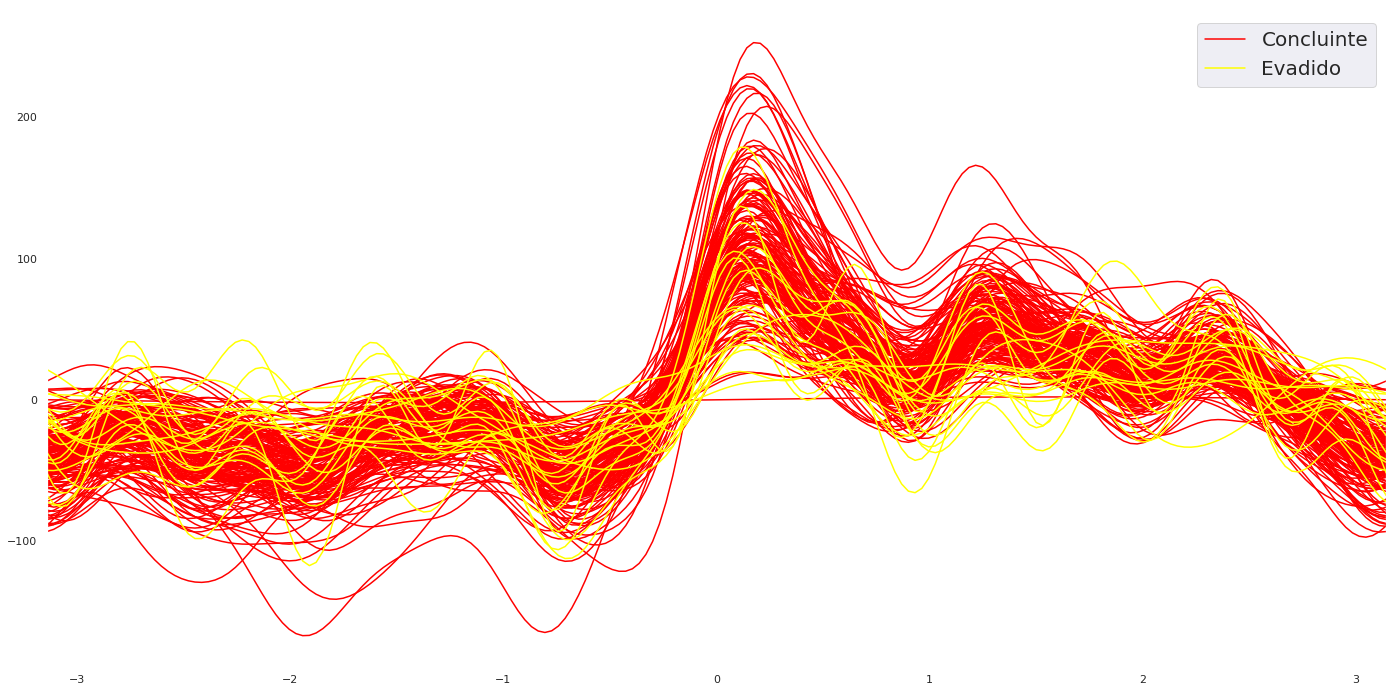

In [46]:
from pandas.plotting import andrews_curves
plt.figure(figsize=(24, 12))
back = andrews_curves(alunos_final, 'Trancou',colormap='autumn')
back.set_facecolor('white')
L=plt.legend(fontsize=20)
L.get_texts()[0].set_text('Concluinte')
L.get_texts()[1].set_text('Evadido')

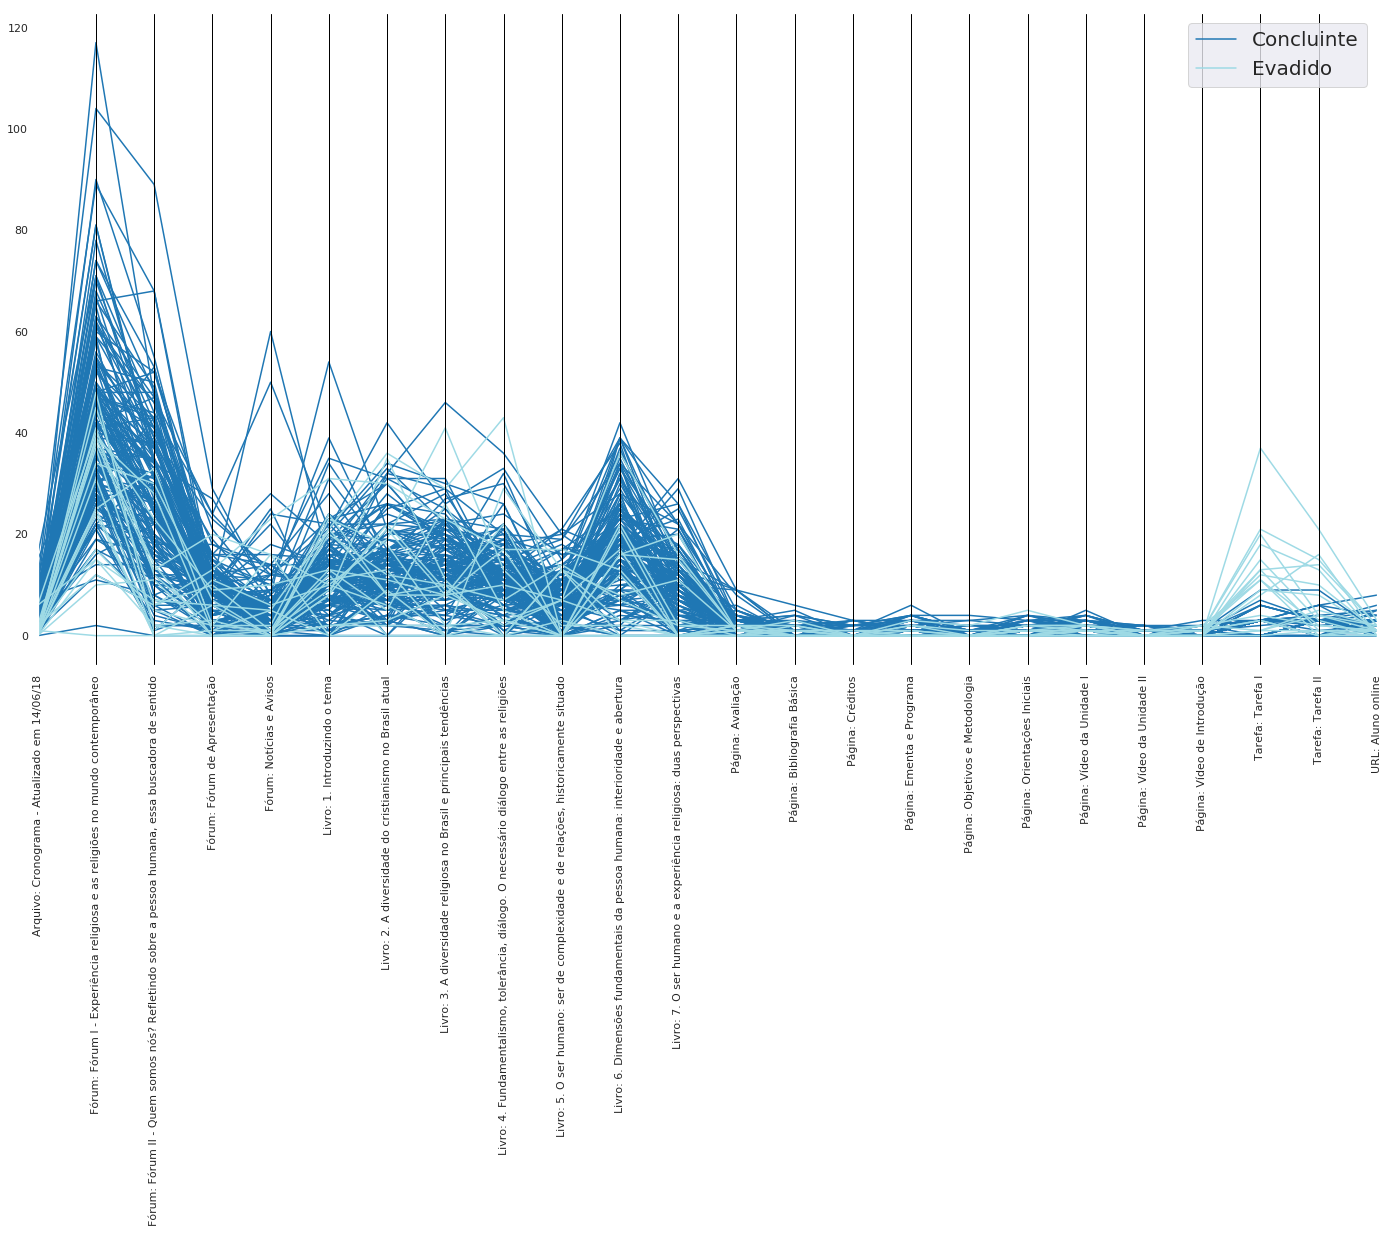

In [47]:
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(24, 12))
plt.xticks(rotation=90)
back= parallel_coordinates(alunos_final, 'Trancou',colormap='tab20')
back.set_facecolor('white')
Leg=plt.legend(fontsize=20)
Leg.get_texts()[0].set_text('Concluinte')
Leg.get_texts()[1].set_text('Evadido')

In [48]:
alunos_final.corr()

,Arquivo: Cronograma - Atualizado em 14/06/18,Fórum: Fórum I - Experiência religiosa e as religiões no mundo contemporâneo,"Fórum: Fórum II - Quem somos nós? Refletindo sobre a pessoa humana, essa buscadora de sentido",Fórum: Fórum de Apresentação,Fórum: Notícias e Avisos,Livro: 1. Introduzindo o tema,Livro: 2. A diversidade do cristianismo no Brasil atual,Livro: 3. A diversidade religiosa no Brasil e principais tendências,"Livro: 4. Fundamentalismo, tolerância, diálogo. O necessário diálogo entre as religiões","Livro: 5. O ser humano: ser de complexidade e de relações, historicamente situado",...,Página: Ementa e Programa,Página: Objetivos e Metodologia,Página: Orientações Iniciais,Página: Vídeo da Unidade I,Página: Vídeo da Unidade II,Página: Vídeo de Introdução,Tarefa: Tarefa I,Tarefa: Tarefa II,Trancou,URL: Aluno online
Arquivo: Cronograma - Atualizado em 14/06/18,1.000000,0.264662,0.233958,0.308704,0.194114,0.117425,0.159557,0.124155,0.079615,0.111120,...,0.314182,0.100706,0.180341,0.152624,0.084522,0.203284,0.017083,0.091154,-0.179274,0.264777
Fórum: Fórum I - Experiência religiosa e as religiões no mundo contemporâneo,0.264662,1.000000,0.704580,0.504721,0.442753,0.440215,0.384964,0.396525,0.345873,0.314080,...,0.242670,0.124398,0.233025,0.298994,0.205973,0.090444,-0.041102,0.075326,-0.248080,0.156193
"Fórum: Fórum II - Quem somos nós? Refletindo sobre a pessoa humana, essa buscadora de sentido",0.233958,0.704580,1.000000,0.422075,0.319415,0.328443,0.255881,0.335631,0.305669,0.466589,...,0.261112,0.183094,0.254316,0.255184,0.290877,0.174667,-0.094446,0.067475,-0.336935,0.126291
Fórum: Fórum de Apresentação,0.308704,0.504721,0.422075,1.000000,0.352042,0.358429,0.132357,0.184183,0.151125,0.293507,...,0.159016,0.185753,0.215817,0.279457,0.074957,0.233746,0.011929,0.092738,-0.182729,0.276076
Fórum: Notícias e Avisos,0.194114,0.442753,0.319415,0.352042,1.000000,0.152717,0.208419,0.192649,0.094144,0.142609,...,0.136516,0.130224,0.173949,0.045466,0.124363,0.045705,0.071131,0.088433,-0.028779,-0.030089
Livro: 1. Introduzindo o tema,0.117425,0.440215,0.328443,0.358429,0.152717,1.000000,0.437446,0.357972,0.323811,0.381133,...,0.237466,0.374730,0.186655,0.575309,0.372793,0.270250,0.176891,0.047854,0.027623,0.019089
Livro: 2. A diversidade do cristianismo no Brasil atual,0.159557,0.384964,0.255881,0.132357,0.208419,0.437446,1.000000,0.637657,0.451763,0.229012,...,0.065401,0.123967,0.080954,0.318015,0.145780,0.095969,0.184735,0.132347,0.020333,-0.021076
Livro: 3. A diversidade religiosa no Brasil e principais tendências,0.124155,0.396525,0.335631,0.184183,0.192649,0.357972,0.637657,1.000000,0.494695,0.286879,...,0.046305,0.168494,0.041546,0.196877,0.135883,0.001644,0.208608,0.125045,-0.109745,-0.043050
"Livro: 4. Fundamentalismo, tolerância, diálogo. O necessário diálogo entre as religiões",0.079615,0.345873,0.305669,0.151125,0.094144,0.323811,0.451763,0.494695,1.000000,0.216792,...,0.227556,0.210241,0.177347,0.282638,0.204613,-0.000281,0.038723,0.035448,-0.089270,0.021066
"Livro: 5. O ser humano: ser de complexidade e de relações, historicamente situado",0.111120,0.314080,0.466589,0.293507,0.142609,0.381133,0.229012,0.286879,0.216792,1.000000,...,0.119918,0.145815,0.077141,0.270911,0.395494,0.265294,-0.101645,-0.094470,-0.089539,0.076895


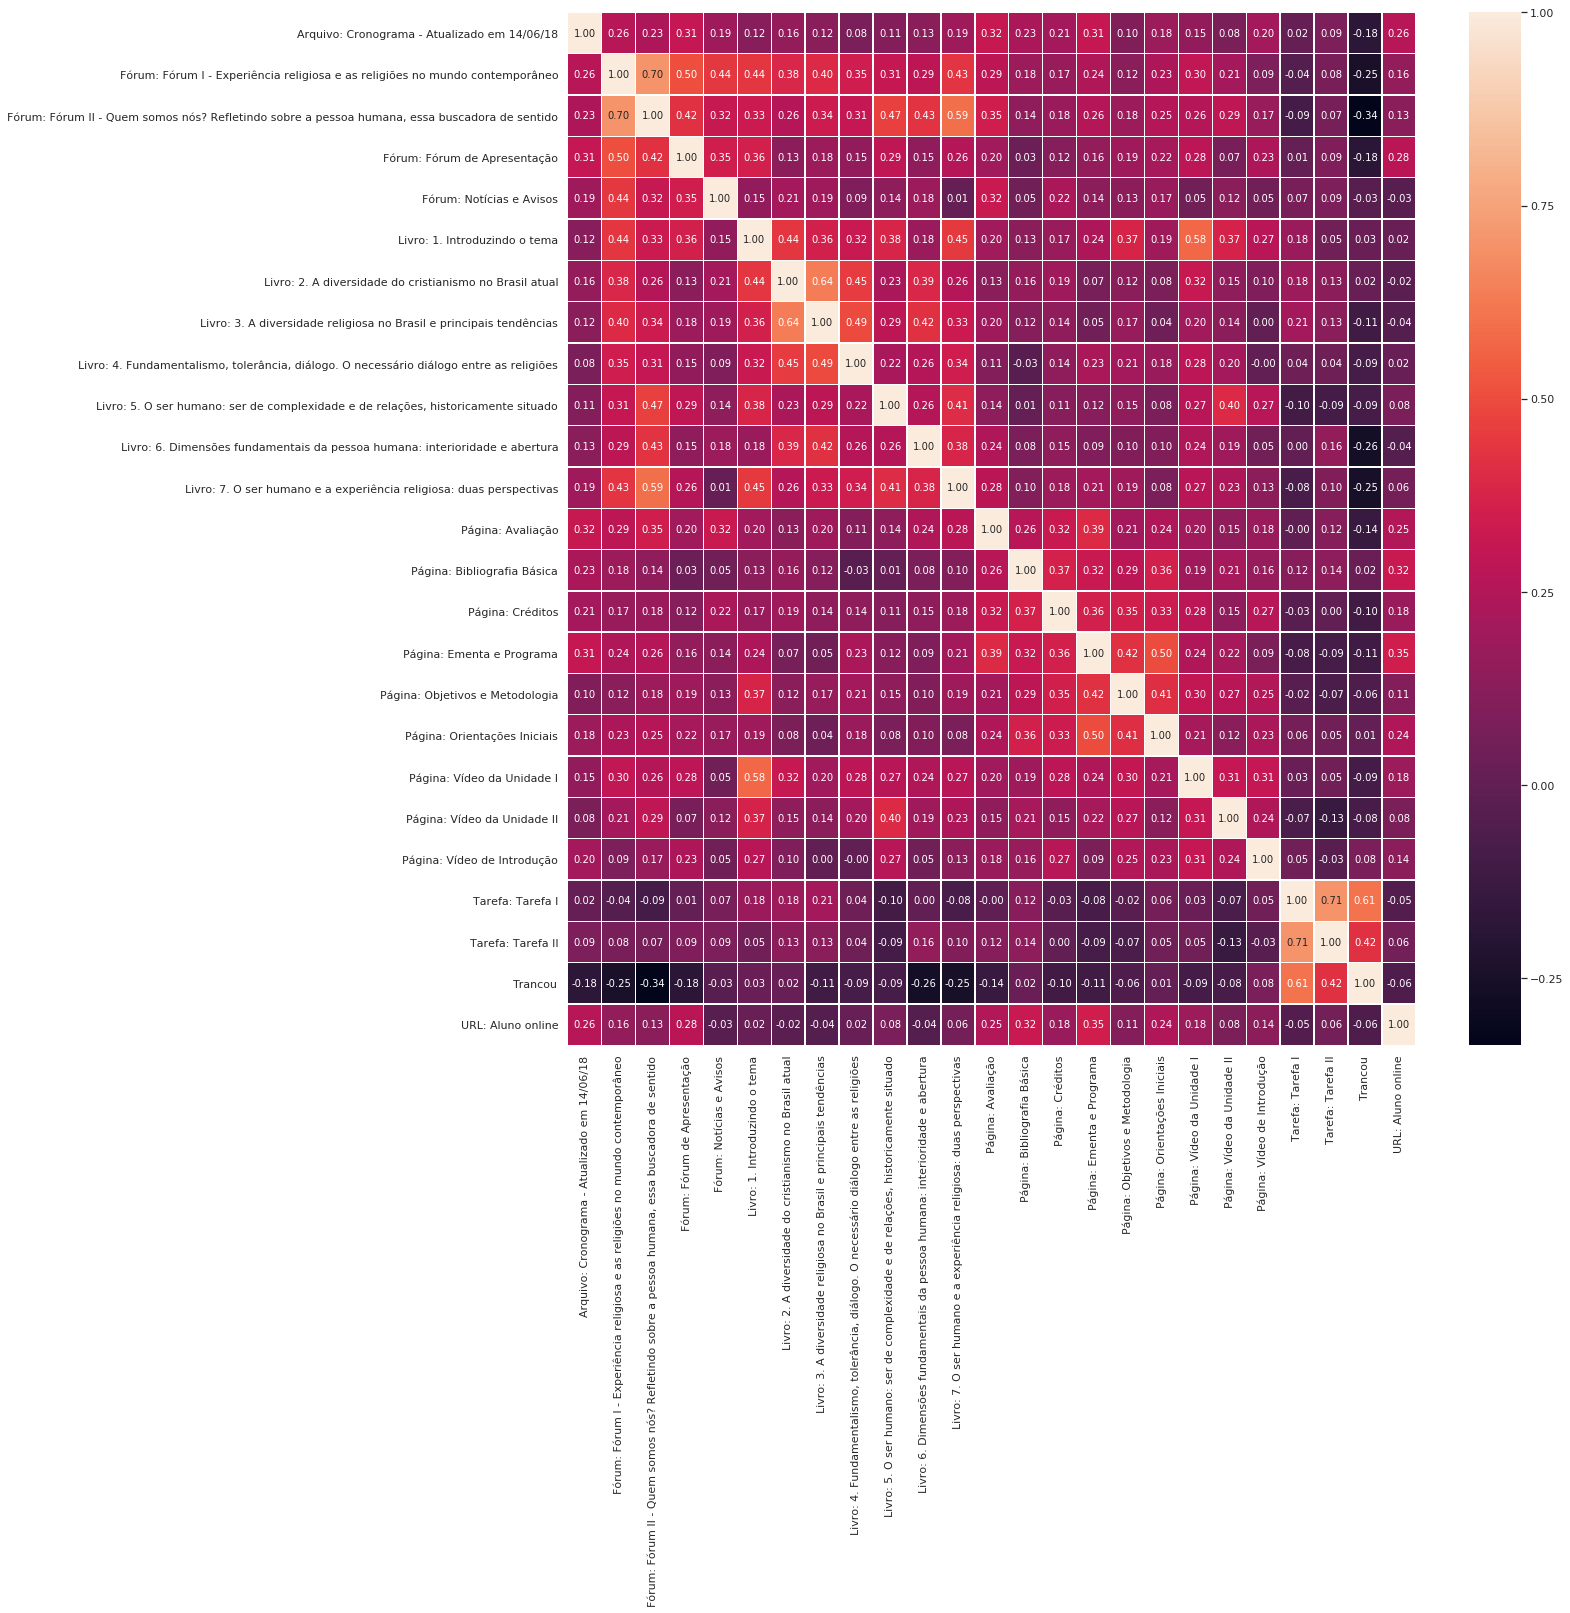

In [51]:
f,ax = plt.subplots(figsize=(19, 19))
sns.heatmap(alunos_final.corr(), annot=True, linewidths=.4, fmt= '.2f',ax=ax)
plt.show()